# Morphology Feature Extraction
First we load all the data and names:

In [1]:
from skimage import io
import os
import numpy as np
import organoid_prediction_python as opp
import pandas as pd

# needs to be changed to repository directory
home_directory = r"C:\Users\savill\OneDrive\Documents\PhD Jesse\Embryonic_organoid_prediction\Processing dataset for Paper\TLS_2D_morphostate_investigation/"
folder_masks = home_directory + r"image_data\Processed Data\Masks Brightfield\96h"
folder_bf = home_directory + r"image_data\Processed Data\Focussed Images\96h\Brightfield"
folder_bra = home_directory + r"image_data\Processed Data\Focussed Images\96h\Brachyury"

bf_collection = io.imread_collection(folder_bf+"/*.tif")
file_names_bf = [os.path.split(fname)[1] for fname in bf_collection.files]

bra_collection = io.imread_collection(folder_bra+"/*.tif")
file_names_bra = [os.path.split(fname)[1] for fname in bra_collection.files]

mask_collection = io.imread_collection(folder_masks+"/*.tif")
file_names_mask = [os.path.split(fname)[1] for fname in mask_collection.files]

## Simple Morphology
Here we calculate the basic morphology features using the normal masks:

In [2]:
dfs = []
for mask, img in zip(mask_collection,bf_collection):
        dfs.append(pd.DataFrame(opp.simple_brightfield_regionprops(mask,img)))

# adding information from all images to one dataframe
df =  pd.concat(dfs,axis =0,ignore_index=True)

# Converting pixel measurements to um measurements
pixel_size = 2.7493
length_columns = ["axis","perimeter","diameter"]
for column in df.columns:
    if any([length in column for length in length_columns]):
        df[column] = df[column].to_numpy() * pixel_size
    if ("area" in column) and ("fraction" not in column): 
        df[column] = df[column].to_numpy() * (pixel_size**2)

sample_identifier = opp.extract_sample_identifiers(file_names_bf)
output_dataframe = pd.concat([sample_identifier.drop("Filename",axis=1),df],axis=1)
output_dataframe.set_index(["Run","Plate","ID"],inplace=True)
output_dataframe

area    perimeter  axis_major_length   
Run Plate ID                                                   
RR  1     A1   111059.251650  1240.883462         383.258637  \
          A2    97302.507758  1175.729218         369.716726   
          A3   104324.494063  1213.666781         379.840070   
          A4   106637.441113  1265.317321         437.670410   
          A5    91693.989094  1175.338445         413.709182   
...                      ...          ...                ...   
TR  2     H8   111134.838154  1281.489393         405.046069   
          H9   125088.106959  1389.507526         449.765600   
          H10  128799.404350  1400.733636         444.001992   
          H11  119313.297985  1343.308177         473.874839   
          H12  123924.074784  1343.631905         447.890306   

               axis_minor_length  eccentricity  feret_diameter_max  solidity   
Run Plate ID                                                                   
RR  1     A1          369.781882      0.262851          394.215492  0.990962  \
          A2          337.432685      0.408677          383.997596  0.989014   
          A3          350.359073      0.386270          388.313686  0.986632   
          A4          312.977592      0.699023          462.086916  0.985471   
          A5          283.375481      0.728578          408.463086  0.987304   
...                          ...           ...                 ...       ...   
TR  2     H8          354.633456      0.483148          426.097154  0.983741   
          H9          362.602919      0.591637          478.386100  0.973528   
          H10         377.019027      0.528171          461.129001  0.970995   
          H11         326.472498      0.724816          463.075495  0.971624   
          H12         354.659675      0.610722          460.710825  0.990096   

               aspect_ratio  
Run Plate ID                 
RR  1     A1       0.964836  
          A2       0.912679  
          A3       0.922386  
          A4       0.715099  
          A5       0.684963  
...                     ...  
TR  2     H8       0.875539  
          H9       0.806204  
          H10      0.849138  
          H11      0.688942  
          H12      0.791845  

[576 rows x 8 columns]

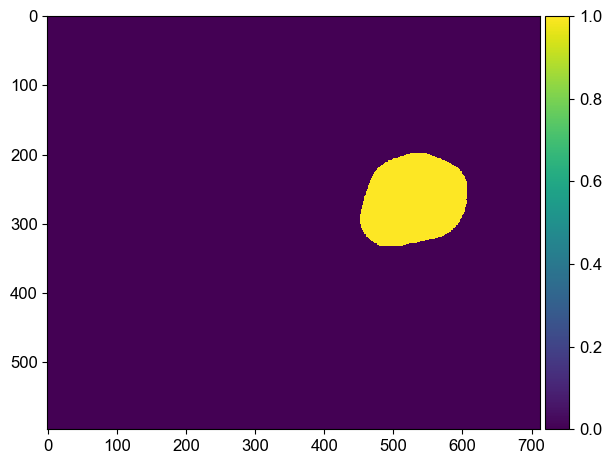

In [3]:
io.imshow(mask)

Saving the table

In [4]:
output_location = home_directory + r"tabular_data\96h"

if not os.path.exists(output_location):
   os.makedirs(output_location)
   print("The new directory is created!")

output_dataframe.to_csv(f"{output_location}/simple_shape_features_96h.csv")

## Straight Morphology
Complex morphology is calculated using the straightened masks as implemented in MOrgAna. First we'll test the straightening and then do the analysis:

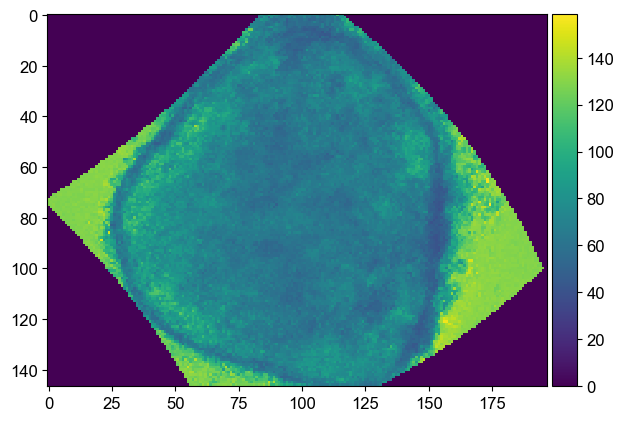

In [5]:
idx = 12
ma_test, bf_test = opp.straighten_mask_and_image(mask_collection[idx],bf_collection[idx])
io.imshow(bf_test)

In [6]:
%%time

straight_masks = []
straight_bra = []

for mask, img in zip(mask_collection,bra_collection):
    ma_straight, bra_straight = opp.straighten_mask_and_image(mask,img)
    straight_masks.append(ma_straight)
    straight_bra.append(bra_straight)
    
straight_morgana_features = opp.calculate_morgana_shapes(straight_masks,mask_collection.files)
straight_morgana_features

CPU times: total: 21min 41s
Wall time: 17min 45s


,area,eccentricity,major_axis_length,minor_axis_length,equivalent_diameter,perimeter,extent,orientation,form_factor,input_file,...,locoefa_coeff_42,locoefa_coeff_43,locoefa_coeff_44,locoefa_coeff_45,locoefa_coeff_46,locoefa_coeff_47,locoefa_coeff_48,locoefa_coeff_49,locoefa_coeff_50,locoefa_coeff_51
0,14763,0.204416,138.757407,135.82742,137.101551,486.801082,0.792347,0.052614,1.277376,result_segmentation\FK223_run_RR_PLATE_1_ID_A1...,...,0.091674,0.069202,0.060781,0.057111,0.038372,0.036317,0.027287,0.008082,0.018812,0.0
1,13182,0.495756,140.092756,121.665201,129.552475,460.445743,0.758676,-0.311135,1.27987,result_segmentation\FK223_run_RR_PLATE_1_ID_A2...,...,0.051366,0.016705,0.060622,0.025176,0.064008,0.042461,0.022831,0.022985,0.00643,0.0
2,13642,0.370966,136.98352,127.209244,131.793527,470.499567,0.773356,-0.15131,1.29131,result_segmentation\FK223_run_RR_PLATE_1_ID_A3...,...,0.053205,0.084615,0.08204,0.065715,0.01235,0.041848,0.056991,0.024533,0.030353,0.0
3,14075,0.696676,158.765611,113.896184,133.868766,492.570635,0.708247,0.086875,1.371762,result_segmentation\FK223_run_RR_PLATE_1_ID_A4...,...,0.042831,0.052442,0.015186,0.077141,0.058373,0.044764,0.012179,0.022036,0.009682,0.0
4,12043,0.724564,149.481243,103.023653,123.82901,432.333044,0.772879,-0.076661,1.235072,result_segmentation\FK223_run_RR_PLATE_1_ID_A5...,...,0.04048,0.075394,0.028797,0.051949,0.02492,0.066306,0.01041,0.022656,0.013362,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,15244,0.613189,158.522714,125.222827,139.317133,502.386868,0.716185,-0.12591,1.317552,result_segmentation\FK223_run_TR_PLATE_2_ID_H8...,...,0.03891,0.026287,0.041575,0.034299,0.044995,0.083258,0.059589,0.029589,0.034786,0.0
572,16797,0.654635,170.419926,128.828062,146.241597,537.972655,0.738589,0.088982,1.371131,result_segmentation\FK223_run_TR_PLATE_2_ID_H9...,...,0.017114,0.056343,0.020858,0.030127,0.032217,0.022169,0.061318,0.028961,0.022945,0.0
573,16856,0.5526,162.653011,135.562623,146.498211,536.499567,0.724522,0.042767,1.358859,result_segmentation\FK223_run_TR_PLATE_2_ID_H1...,...,0.084558,0.054256,0.011268,0.020152,0.05332,0.038132,0.044126,0.029521,0.038663,0.0
574,16254,0.784977,184.143146,114.081235,143.858387,527.144228,0.815309,-0.080494,1.360469,result_segmentation\FK223_run_TR_PLATE_2_ID_H1...,...,0.038746,0.043574,0.003335,0.037013,0.025072,0.034177,0.019411,0.035867,0.023474,0.0


In [7]:
df = straight_morgana_features

pixel_size = 2.7493
length_columns = ["axis","perimeter","diameter"]
for column in df.columns:
    if any([length in column for length in length_columns]):
        df[column] = df[column].to_numpy() * pixel_size
    if ("area" in column) and ("fraction" not in column): 
        df[column] = df[column].to_numpy() * (pixel_size**2)
        
sample_identifier = opp.extract_sample_identifiers(file_names_bf)
output_dataframe = pd.concat([sample_identifier.drop("Filename",axis=1),df.drop("input_file",axis=1)],axis=1)
output_dataframe.set_index(["Run","Plate","ID"],inplace=True)
output_dataframe

area eccentricity major_axis_length minor_axis_length   
Run Plate ID                                                                    
RR  1     A1   111588.357184     0.204416        381.485738        373.430325  \
          A2    99638.130759     0.495756        385.157015        334.494138   
          A3   103115.109985     0.370966         376.60879        349.736374   
          A4   106388.005647     0.696676        436.494294        313.134779   
          A5    91028.827851     0.724564        410.968782        283.242929   
...                      ...          ...               ...               ...   
TR  2     H8    115224.06807     0.613189        435.826496        344.275119   
          H9   126962.652281     0.654635        468.535501        354.186991   
          H10  127408.612659       0.5526        447.181922         372.70232   
          H11  122858.305064     0.784977        506.264752         313.64354   
          H12  125949.793115     0.642375        459.440398        352.110634   

              equivalent_diameter    perimeter    extent orientation   
Run Plate ID                                                           
RR  1     A1           376.933295  1338.362215  0.792347    0.052614  \
          A2           356.178618  1265.903481  0.758676   -0.311135   
          A3           362.339945  1293.544459  0.773356    -0.15131   
          A4           368.045399  1354.224446  0.708247    0.086875   
          A5           340.443099  1188.613239  0.772879   -0.076661   
...                           ...          ...       ...         ...   
TR  2     H8           383.024594  1381.212217  0.716185    -0.12591   
          H9           402.062022   1479.04822  0.738589    0.088982   
          H10          402.767531  1474.998259  0.724522    0.042767   
          H11          395.509864  1449.277625  0.815309   -0.080494   
          H12          400.455063  1417.067572  0.767526    0.027223   

              form_factor aspect_ratio  ... locoefa_coeff_42 locoefa_coeff_43   
Run Plate ID                            ...                                     
RR  1     A1     1.277376     1.021571  ...         0.091674         0.069202  \
          A2      1.27987     1.151461  ...         0.051366         0.016705   
          A3      1.29131     1.076836  ...         0.053205         0.084615   
          A4     1.371762      1.39395  ...         0.042831         0.052442   
          A5     1.235072     1.450941  ...          0.04048         0.075394   
...                   ...          ...  ...              ...              ...   
TR  2     H8     1.317552     1.265925  ...          0.03891         0.026287   
          H9     1.371131     1.322848  ...         0.017114         0.056343   
          H10    1.358859     1.199837  ...         0.084558         0.054256   
          H11    1.360469     1.614141  ...         0.038746         0.043574   
          H12    1.268743     1.304818  ...         0.043562          0.08665   

              locoefa_coeff_44 locoefa_coeff_45 locoefa_coeff_46   
Run Plate ID                                                       
RR  1     A1          0.060781         0.057111         0.038372  \
          A2          0.060622         0.025176         0.064008   
          A3           0.08204         0.065715          0.01235   
          A4          0.015186         0.077141         0.058373   
          A5          0.028797         0.051949          0.02492   
...                        ...              ...              ...   
TR  2     H8          0.041575         0.034299         0.044995   
          H9          0.020858         0.030127         0.032217   
          H10         0.011268         0.020152          0.05332   
          H11         0.003335         0.037013         0.025072   
          H12         0.034548         0.035318         0.041274   

              locoefa_coeff_47 locoefa_coeff_48 locoefa_coeff_49   
Run Plate ID              

Now we calculate the extent of polarisation of the brachyury signal using the straightened mask and straightened brachyury signal:

In [8]:
polarisation_props = opp.measure_brachyury_polarisation(straight_bra,straight_masks,file_names_bra)
sample_identifier = opp.extract_sample_identifiers(polarisation_props["filenames"])
df_polarisation = pd.concat([sample_identifier.drop("Filename",axis=1),polarisation_props.drop("filenames",axis=1)],axis=1)
df_polarisation.set_index(["Run","Plate","ID"],inplace=True)

df_polarisation

first_axis_polarisation  second_axis_polarisation
Run Plate ID                                                    
RR  1     A1                  0.027743                  0.018767
          A2                  0.013417                  0.031259
          A3                  0.041057                  0.014838
          A4                  0.053157                  0.007887
          A5                  0.038555                  0.006555
...                                ...                       ...
TR  2     H8                  0.010821                  0.026928
          H9                  0.035616                  0.026081
          H10                 0.009338                  0.004076
          H11                 0.012343                  0.042325
          H12                 0.001894                  0.008426

[576 rows x 2 columns]

In [9]:
output_location = home_directory + r"tabular_data\96h"

if not os.path.exists(output_location):
   os.makedirs(output_location)
   print("The new directory is created!")

output_dataframe.to_csv(f"{output_location}/straight_morgana_shape_features_96h.csv")
df_polarisation.to_csv(f"{output_location}/straight_morgana_brachyury_polarisation_96h.csv")